In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [4]:
import tensorflow_similarity as tfsim
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.distance_metrics import avg_neg, avg_pos, dist_gap, max_pos, min_neg
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import select_examples
from tensorflow_similarity.visualization import viz_neigbors_imgs
from tensorflow_similarity.visualization import confusion_matrix

In [5]:
# make sure TF don't blew up
tf_cap_memory()
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.4.0
TensorFlow Similarity 0.7.6


In [6]:
BATCH_SIZE = 64 #@param {type:"integer"}
CLASS_PER_BATCH = 8 #@param {type:"integer"}
BATCH_PER_EPOCH = 3000 #@param {type:"integer"}
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')
sampler = MultiShotMemorySampler(x_train, y_train, class_per_batch=CLASS_PER_BATCH, batch_size=BATCH_SIZE, batch_per_epoch=BATCH_PER_EPOCH)

indexing classes: 100%|██████████| 60000/60000 [00:00<00:00, 2181919.58it/s]Warmup:True



In [7]:
data_augmentation = tf.keras.Sequential([
  # layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
  ])

In [8]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28, 28, 1))(inputs)
    x = data_augmentation(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 11, activation='relu')(x)

    x = layers.GlobalMaxPool2D()(x)
    x = layers.Flatten()(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)

    # dont make the embedding to large - its slow down the lookups
    e = layers.Dense(32)(x)

    # vs = layers.Dense(2, activation='softplus', name='visual_side')(x)
    vt = layers.Dense(2, activation=None, name='visual_top')(x)
    return SimilarityModel(inputs, [e, vt]) #, vs])
model = get_model()
model.summary()

Model: "similarity_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 28, 28, 1)    0           reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 1)    4           sequential[0][0]                 
___________________________________________________________________________________

In [9]:
import tensorflow_addons as tfa
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard'  #@param ["easy", "semi-hard", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy='hard',
    negative_mining_strategy='hard')

visual_triplet_loss = tfa.losses.TripletSemiHardLoss(distance_metric='L2')

In [10]:
EPOCHS = 3 #@param {type:"integer"}
LR = 0.001  #@param {type:"float"}
model = get_model()
metrics = [dist_gap(distance), min_neg(distance), max_pos(distance)]
metrics = []
model.compile(optimizer=Adam(LR), metrics=metrics, loss=[triplet_loss, visual_triplet_loss])
history = model.fit(sampler, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/3
3000/3000 [==============================] - 41s 12ms/step - loss: 1.2526 - dense_1_loss: 1.0231 - visual_top_loss: 0.2295 - val_loss: 1.0642 - val_dense_1_loss: 0.9657 - val_visual_top_loss: 0.0985
Warmup complete
Epoch 2/3
3000/3000 [==============================] - 37s 12ms/step - loss: 0.9669 - dense_1_loss: 0.8772 - visual_top_loss: 0.0897 - val_loss: 0.9178 - val_dense_1_loss: 0.8373 - val_visual_top_loss: 0.0805
Epoch 3/3
3000/3000 [==============================] - 37s 12ms/step - loss: 0.8338 - dense_1_loss: 0.7681 - visual_top_loss: 0.0658 - val_loss: 0.8589 - val_dense_1_loss: 0.7959 - val_visual_top_loss: 0.0630


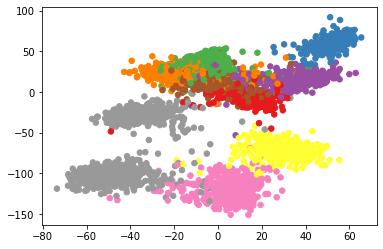

In [11]:
# generate embeddings
NUM_EXAMPLES = 5000
embeddings, vizualized = model.predict(x_test[:NUM_EXAMPLES])
plt.scatter(vizualized[:, 0], vizualized[:, 1], c=y_test[:NUM_EXAMPLES], s=30, cmap='Set1')
plt.show()

In [12]:
# done on mnist digits
# removing activation and trusting the loss
# > magic gives nice clusters!
# Epoch 3/3
# 3000/3000 [==============================] - 37s 12ms/step - loss: 0.0854 - dense_1_loss: 0.0696 - visual_top_loss: 0.0158 - val_loss: 0.1866 - val_dense_1_loss: 0.1698 - val_visual_top_loss: 0.0168

# moving to side way better

# softsign on top look good
# 3000/3000 [==============================] - 39s 13ms/step - loss: 0.1857 - metric_embedding_loss: 0.1443 - visual_top_loss: 0.0414 - val_loss: 0.2907 - val_metric_embedding_loss: 0.2377 - val_visual_top_loss: 0.0530

# softplus on top and relu instread of SELU
# weird corner and loss abopu 0.5


# softsign on top and relu instread of SELU
# weird corner and loss abopu 0.5

# putting on top of l2   with l2 activation not better > creates a circle

#l2 instead of than is better but still struggle after 2 epoc
# loss = 0.7

# tahn push clusters on the corners
# loss 0.5 after 3 epooch

# BATCH 64 - 8 class > better 


#LR 0.0001 and 3 epochs  < bad
# Epoch 3/3
# 3000/3000 [==============================] - 37s 12ms/step - loss: 0.4010 - metric_embedding_loss: 0.3385 - visual_top_loss: 0.0626 - val_loss: 0.4906 - val_metric_embedding_loss: 0.4148 - val_visual_top_loss: 0.0758

# light data aug
# Epoch 2/2
# 3000/3000 [==============================] - 37s 12ms/step - loss: 0.2749 - metric_embedding_loss: 0.2402 - visual_top_loss: 0.0347 - val_loss: 0.2803 - val_metric_embedding_loss: 0.2466 - val_visual_top_loss: 0.0338


# extra dense not working (forgot copypast)

# Epoch 2/2
# 3000/3000 [==============================] - 38s 13ms/step - loss: 0.2800 - metric_embedding_loss: 0.2464 - visual_top_loss: 0.0336 - val_loss: 0.2730 - val_metric_embedding_loss: 0.2510 - val_visual_top_loss: 0.0219


# Single epoch optimization

# batch norm before conv > better
#3000/3000 [==============================] - 39s 13ms/step - loss: 0.8589 - metric_embedding_loss: 0.7002 - visual_top_loss: 0.1587 - val_loss: 0.4307 - val_metric_embedding_loss: 0.3934 - val_visual_top_loss: 0.0373

# Extra dense and batch norm > nope
# 3000/3000 [==============================] - 41s 13ms/step - loss: 0.9501 - metric_embedding_loss: 0.7522 - visual_top_loss: 0.1979 - val_loss: 0.5545 - val_metric_embedding_loss: 0.5118 - val_visual_top_loss: 0.0427

# DENSE 64 > 128 > nope
#3000/3000 [==============================] - 36s 12ms/step - loss: 0.8404 - metric_embedding_loss: 0.6961 - visual_top_loss: 0.1443 - val_loss: 0.4172 - val_metric_embedding_loss: 0.3948 - val_visual_top_loss: 0.0224

# SELU on the conv (no activation before) < better
#3000/3000 [==============================] - 36s 12ms/step - loss: 0.8387 - metric_embedding_loss: 0.6784 - visual_top_loss: 0.1602 - val_loss: 0.3479 - val_metric_embedding_loss: 0.3174 - val_visual_top_loss: 0.0305

# kernelsize 11 < better
#3000/3000 [==============================] - 36s 12ms/step - loss: 0.8449 - metric_embedding_loss: 0.6991 - visual_top_loss: 0.1457 - val_loss: 0.4002 - val_metric_embedding_loss: 0.3687 - val_visual_top_loss: 0.0314

# RELU instead of SELU > nope
#3000/3000 [==============================] - 36s 12ms/step - loss: 0.9284 - metric_embedding_loss: 0.7518 - visual_top_loss: 0.1765 - val_loss: 0.3937 - val_metric_embedding_loss: 0.3587 - val_visual_top_loss: 0.0350

# 2 Conv512 > bad
# 3000/3000 [==============================] - 116s 38ms/step - loss: 0.9625 - metric_embedding_loss: 0.7860 - visual_top_loss: 0.1765 - val_loss: 0.4329 - val_metric_embedding_loss: 0.3950 - val_visual_top_loss: 0.0379


#3000/3000 [==============================] - 37s 12ms/step - loss: 0.9612 - metric_embedding_loss: 0.7691 - visual_top_loss: 0.1920 - val_loss: 0.5485 - val_metric_embedding_loss: 0.4270 - val_visual_top_loss: 0.1216 


#256 layers
# 3000/3000 [==============================] - 36s 12ms/step - loss: 1.0759 - metric_embedding_loss: 0.8544 - visual_top_loss: 0.2215 - val_loss: 0.5257 - val_metric_embedding_loss: 0.4641 - val_visual_top_loss: 0.0616